In [20]:
import uproot as ur
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['legend.frameon']=True
plt.rcParams['legend.edgecolor']='white'
import uproot,glob,ROOT

from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (10, 8)

import gc
pdg=ROOT.TDatabasePDG()

Warning in <TDatabasePDG::TDatabasePDG>: object already instantiated


In [3]:
df=pd.read_pickle("D0bar_lcp_sim.pkl")

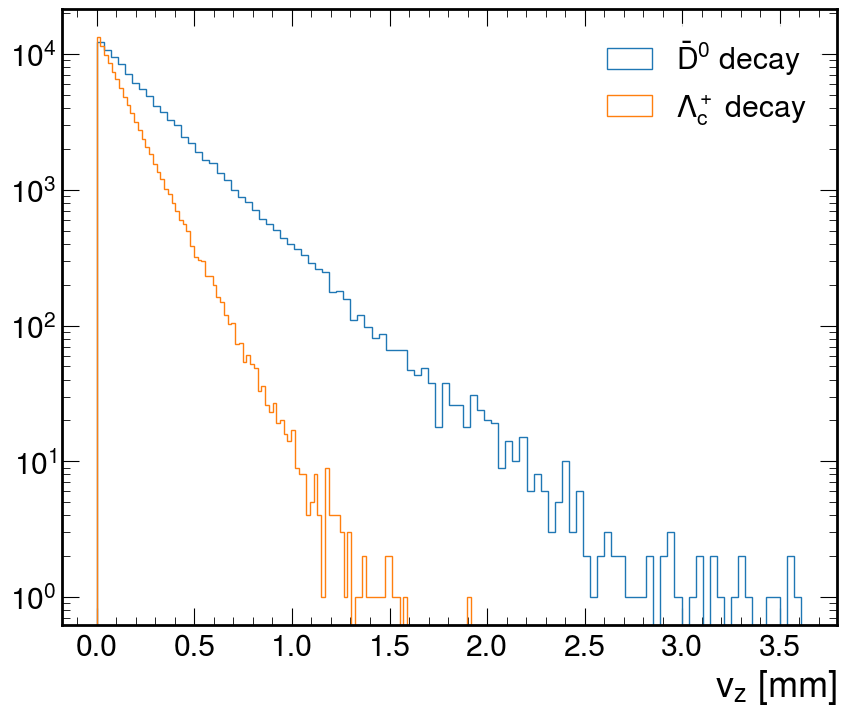

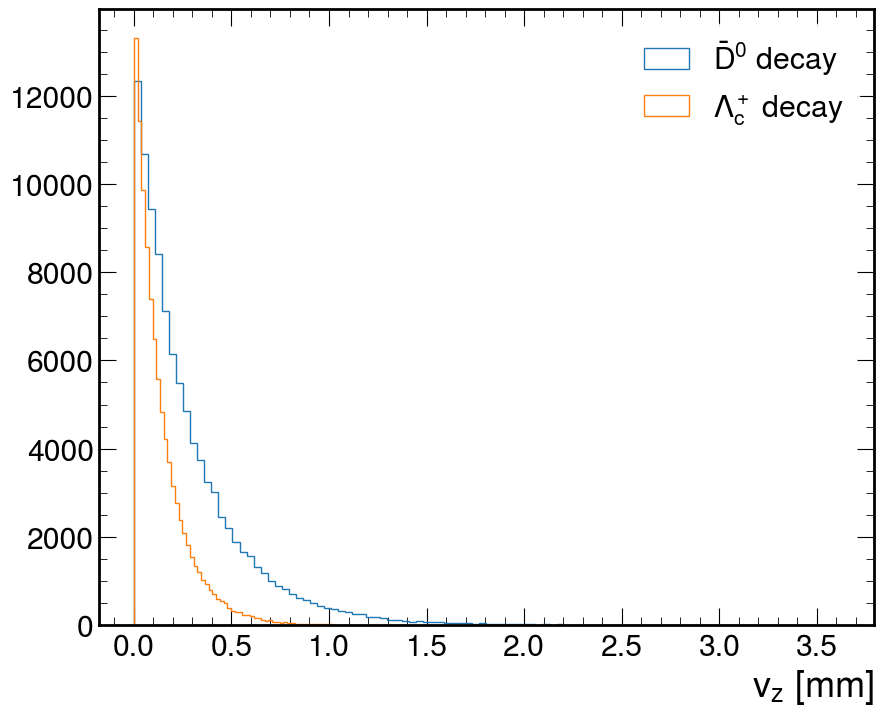

In [4]:
for scale in "log", "linear":
    plt.hist(df.D0_vz, bins=100, histtype='step', label='$\\bar D^0$ decay')
    plt.hist(df.lambdac_vz, bins=100, histtype='step', label='$\\Lambda_c^+$ decay')
    plt.yscale(scale)
    plt.xlabel("$v_z$ [mm]")
    plt.legend()
    plt.show()


In [13]:
# minimum theta of the hadrons from one of the two decay channels
df['min_theta_from_lcp_decay']=np.min([df['p_theta'],df['Km_theta'],df['pip_theta']], axis=0)
df['max_theta_from_lcp_decay']=np.max([df['p_theta'],df['Km_theta'],df['pip_theta']], axis=0)
df['mid_theta_from_lcp_decay']=np.quantile([df['p_theta'],df['Km_theta'],df['pip_theta']], 0.5, axis=0)
df['min_theta_from_D0bar_decay']=np.min([df['Kp_theta'],df['pim_theta']], axis=0)
df['max_theta_from_D0bar_decay']=np.max([df['Kp_theta'],df['pim_theta']], axis=0)
df['nu']=10.6-df.e_E

In [18]:
vzmin=0.027/np.sqrt(12)*3
thmin=9*np.pi/180
q=f"lambdac_vz>{vzmin}"
print(f"{100*len(df.query(q))/len(df):.1f}% of lambda c+ candidates pass vertex cuts")
q=f"D0_vz>{vzmin}"
print(f"{100*len(df.query(q))/len(df):.1f}% of D0 bar candidates pass cuts pass vertex cuts")
q=f"min_theta_from_lcp_decay>{thmin} and lambdac_vz>{vzmin}"
print(f"{100*len(df.query(q))/len(df):.1f}% of lambda c+ candidates pass vertex and MVTX acceptance cuts")
q=f"min_theta_from_D0bar_decay>{thmin} and D0_vz>{vzmin}"
print(f"{100*len(df.query(q))/len(df):.1f}% of D0 bar candidates pass cuts pass vertex and MVTX acceptance cuts")

84.1% of lambda c+ candidates pass vertex cuts
91.8% of D0 bar candidates pass cuts pass vertex cuts
35.5% of lambda c+ candidates pass vertex and MVTX acceptance cuts
68.7% of D0 bar candidates pass cuts pass vertex and MVTX acceptance cuts


Text(0.5, 1.0, 'Proposed MVTX in CLAS12 acceptance ')

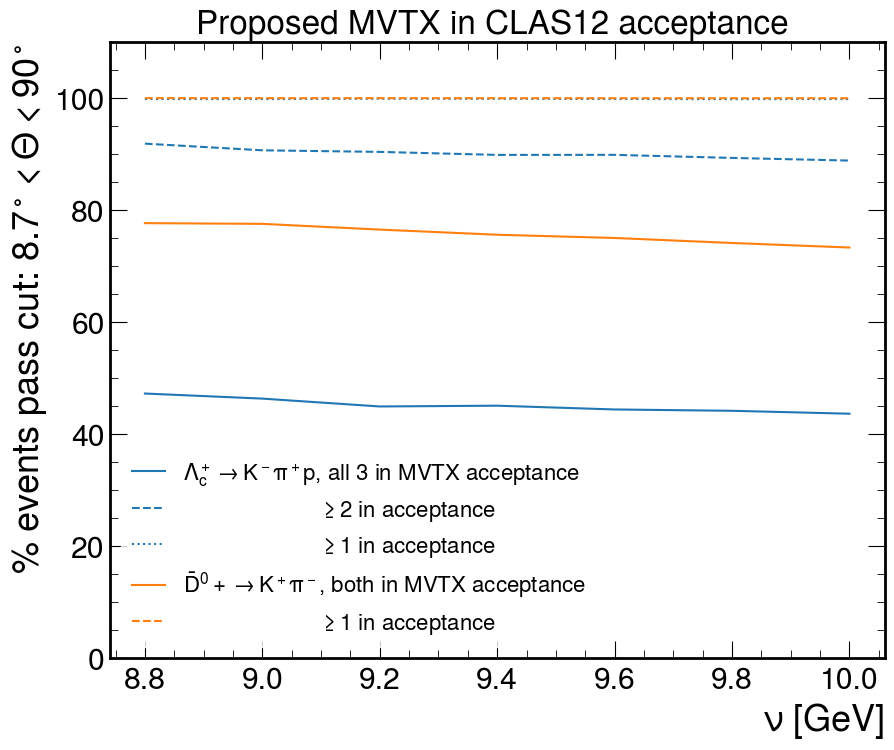

In [96]:
thmin=8.7*np.pi/180
thmax=90*np.pi/180

labels=["$\Lambda_c^+\\rightarrow K^-\\pi^+p$, all 3 in MVTX acceptance",
       "                      $\\geq 2$ in acceptance",
       "                      $\\geq 1$ in acceptance",
       "$\\bar D^0+\\rightarrow K^+\\pi^-$, both in MVTX acceptance",
       "                      $\\geq 1$ in acceptance"]
linestyles="- -- : - --".split()
i=0



for chpart in "lcp", "D0bar":
    for m in "min", "mid", "max":
        if chpart == "D0bar" and m=="mid":
            continue
        q=f"{m}_theta_from_{chpart}_decay>{thmin}"
        if m=="min" or m=="mid":
            q+=f" and max_theta_from_{chpart}_decay<{thmax}"
        if m=="max":
            q+=f" and min_theta_from_{chpart}_decay<{thmax}"
        q_denom=f" min_theta_from_{chpart}_decay>{0*np.pi/180}"
        q+=" and "+ q_denom
        n,x=np.histogram(df.query(q).nu, bins=np.linspace(8.7, 10.1, 8))
        d,x=np.histogram(df.query(q_denom).nu, bins=np.linspace(8.7, 10.1, 8))
        bcs=(x[1:]+x[:-1])/2
        args={}
        args['color']='tab:blue' if chpart=="lcp" else "tab:orange"
        args['ls']=linestyles[i]
        args['label']=labels[i]
        #plt.errorbar(bcs, n/d, np.sqrt(n*(d-n)/d**3),**args)
        plt.errorbar(bcs, n/d*100,**args)
        i+=1
plt.legend(fontsize=16)
plt.xlabel("$\\nu$ [GeV]")
plt.ylabel("% events pass cut: $8.7^\\circ<\\Theta<90^\\circ$")
plt.ylim(0, 110)
plt.title("Proposed MVTX in CLAS12 acceptance ", fontsize=24)


(0.0, 419.95)

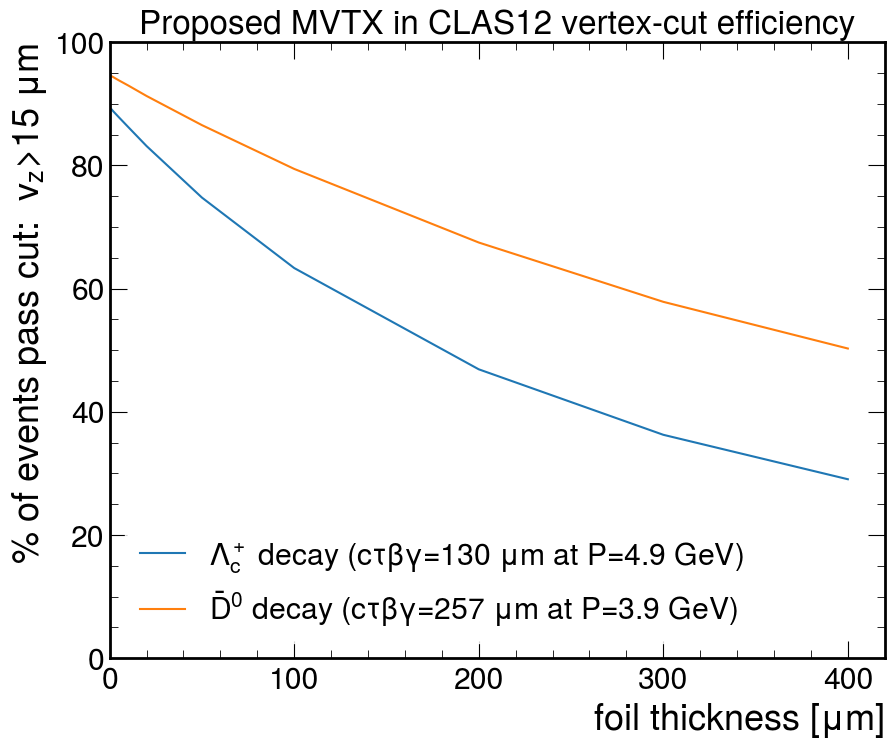

In [87]:
#doverp["D0"]=299792458*1000*4.101e-13/D0bar.Mass()
#doverp["lambdac"]=299792458*1000*2.024e-13/lcp.Mass()




vres=0.005#0.027/np.sqrt(12)
cutoff=3*vres
import random
r=random.Random()
lendf=len(df)
u=np.array([r.uniform(0, 1) for i in range(lendf)])

labels=[f"$\\Lambda_c^+$ decay ($c\\tau\\beta\\gamma$={299792458*1000*2.024e-13*4.9/2.28646*1e3:.0f} $\\mu$m at P=4.9 GeV)", \
       f"$\\bar D^0$ decay ($c\\tau\\beta\\gamma$={299792458*1000*4.101e-13*3.9/1.86484*1e3:.0f} $\\mu$m at P=3.9 GeV)"]
for i in range(2):
    chpar="lambdac" if i == 0 else "D0"
    thicknesses=np.array([0.001, 0.002, 0.005,0.010, 0.020, 0.050, 0.1, 0.2, 0.3, 0.4])
    fs=[]
    for t in thicknesses:
        fs.append(len(df[df[f"{chpar}_vz"]-u*t>cutoff])/lendf)
    fs = np.array(fs)
    plt.plot(thicknesses*1000, fs*100, label=labels[i])
plt.xlabel("foil thickness [$\\mu$m]")
plt.ylabel(f"% of events pass cut:  $v_z$>{cutoff*1000:.0f} $\\mu$m")
plt.title(f"Proposed MVTX in CLAS12 vertex-cut efficiency", fontsize=24)
plt.legend()
plt.ylim(0, 100)
plt.xlim(0)

In [69]:
27/np.sqrt(12)

7.794228634059948

In [84]:
norm.cdf(5)

0.9999997133484281

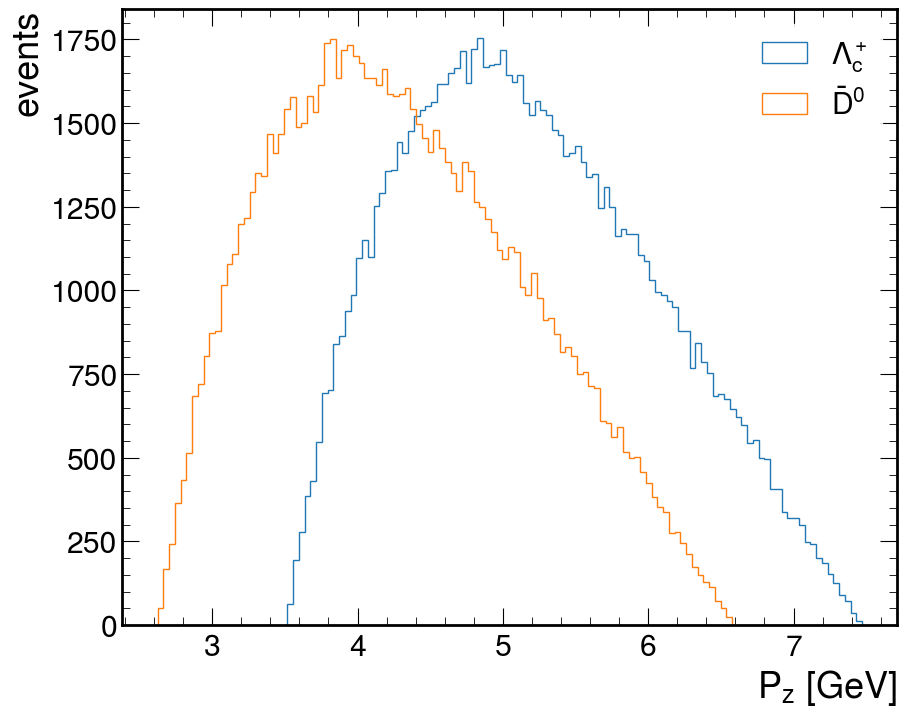

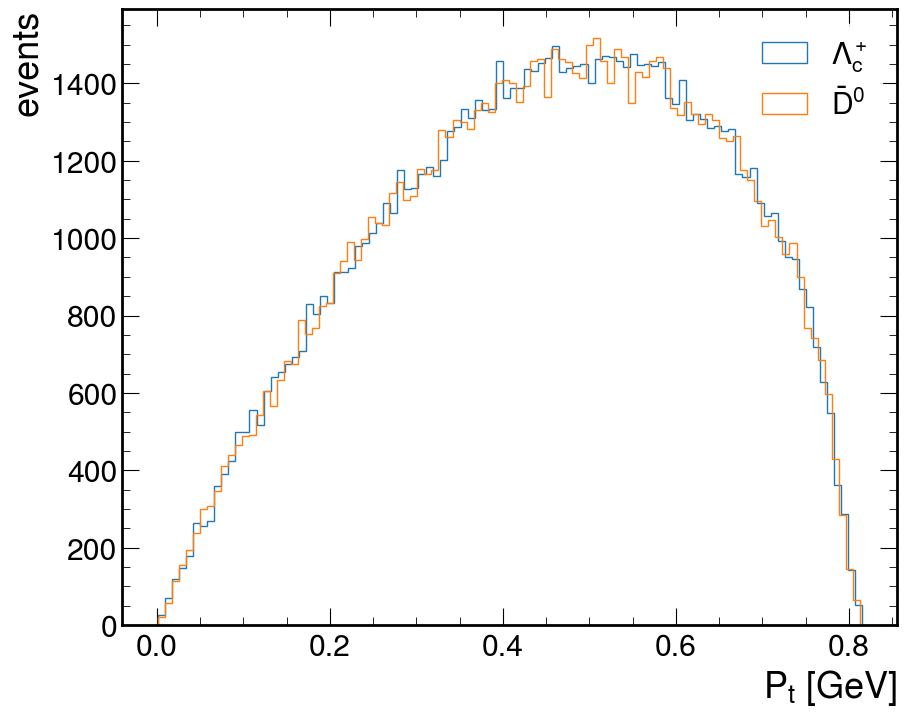

In [92]:
plt.hist(df.lambdac_pz, bins=100, histtype='step', label='$\\Lambda_c^+$')
plt.hist(df.D0_pz, bins=100, histtype='step', label='$\\bar D^0$')
plt.xlabel("$P_z$ [GeV]")
plt.ylabel("events")
plt.legend()
plt.show()
plt.hist(df.eval("sqrt(lambdac_px**2+lambdac_py**2)"), bins=100, histtype='step', label='$\\Lambda_c^+$')
plt.hist(df.eval("sqrt(D0_px**2+D0_py**2)"), bins=100, histtype='step', label='$\\bar D^0$')
plt.xlabel("$P_t$ [GeV]")
plt.ylabel("events")
plt.legend()
plt.show()

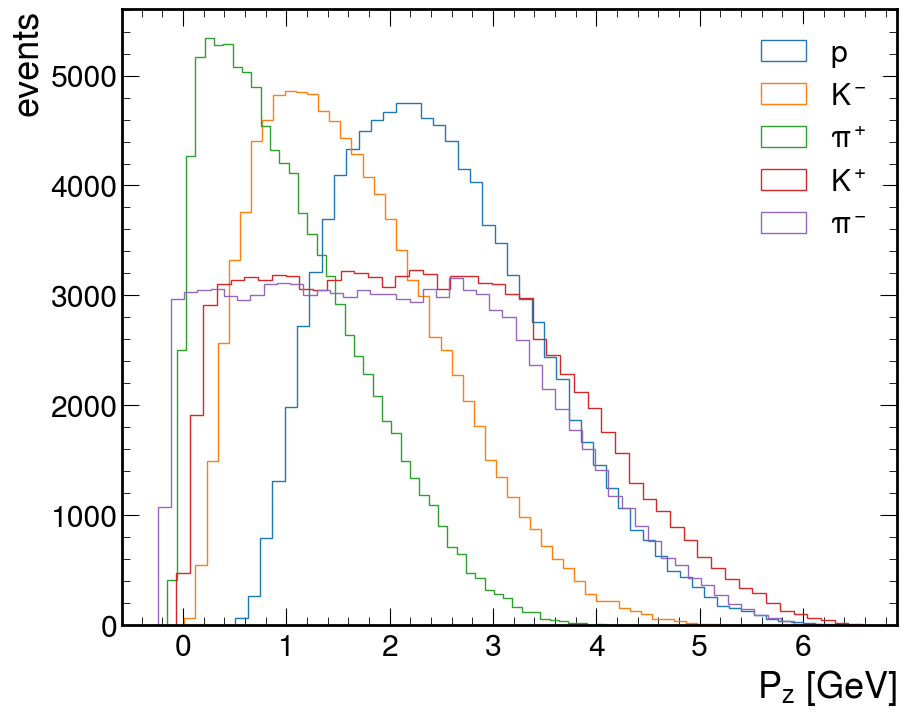

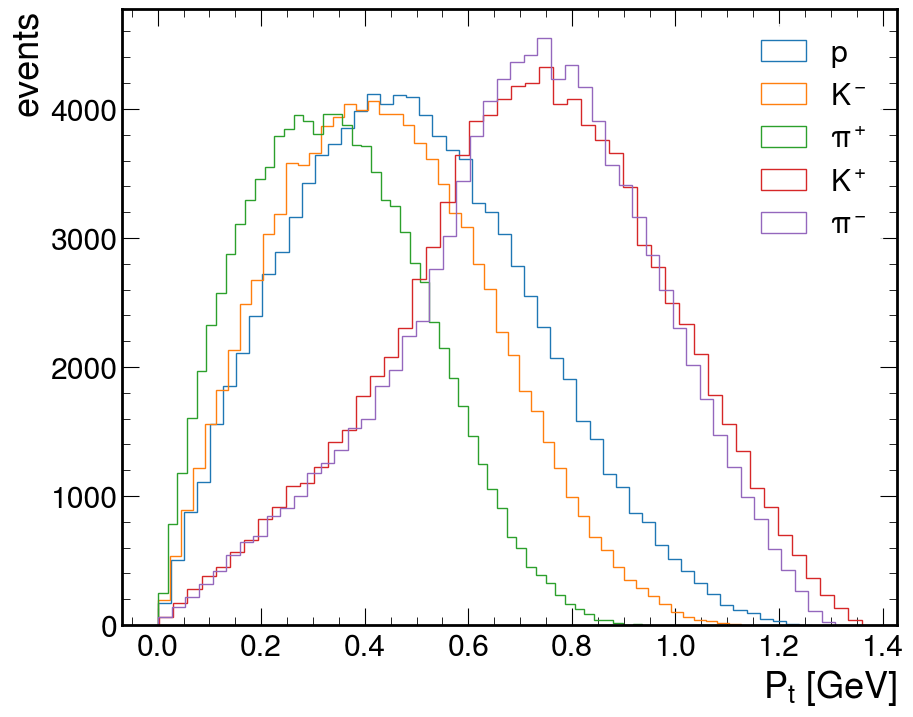

In [100]:
names="p Km pip Kp pim".split()
texs="p $K^-$ $\\pi^+$ $K^+$ $\\pi^-$".split()
for i in range(5):
    plt.hist(df[f"{names[i]}_pz"], bins=50, histtype='step', label=texs[i])
plt.xlabel("$P_z$ [GeV]")
plt.ylabel("events")
plt.legend()
plt.show()
for i in range(5):
    plt.hist(df.eval(f"sqrt({names[i]}_px**2+{names[i]}_py**2)"), bins=50, histtype='step', label=texs[i])
plt.xlabel("$P_t$ [GeV]")
plt.ylabel("events")
plt.legend()
plt.show()